In [1]:
import pandas as pd
import pickle
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dropout, Dense, Embedding, LSTM, Conv1D, MaxPooling1D

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef, confusion_matrix

import logging
logging.basicConfig(level=logging.INFO)

Using TensorFlow backend.


In [48]:
df = pd.read_csv("./../Data/preprocessed_train_data.csv")
df = df.loc[df['is_humor'] == 1]
df["humor_controversy"] = df.humor_controversy.astype(int)
df

,Unnamed: 0,id,text,is_humor,humor_rating,humor_controversy,offense_rating
0,0,1,ten best stat nobody ev com clos elev walk roo...,1,2.42,1,0.20
1,1,2,man insert advert class wif want next day rece...,1,2.50,1,1.10
2,2,3,many men tak op beer non op tim bring couch,1,1.95,0,2.40
3,3,4,tell mom hit 1200 twit follow point broth own ...,1,2.11,1,0.00
4,4,5,ros dead lov fak wed bas fun cak,1,2.78,0,0.10
...,...,...,...,...,...,...,...
7991,7991,7992,sin lik virus bet keep,1,2.13,1,0.10
7993,7993,7994,daught want cinderell them birthday party mad ...,1,3.70,0,0.00
7996,7996,7997,aspirin whit work sorry,1,1.33,0,3.85
7997,7997,7998,today be celebr independ britain plan escap canad,1,2.55,0,0.00


In [49]:
def prepare_model_input(X_train, X_test,MAX_NB_WORDS=75000,MAX_SEQUENCE_LENGTH=500):
    np.random.seed(7)
    text = np.concatenate((X_train, X_test), axis=0)
    text = np.array(text)
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    tokenizer.fit_on_texts(text)
    pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    print(text.shape)
    X_train_Glove = text[0:len(X_train), ]
    X_test_Glove = text[len(X_train):, ]
    embeddings_dict = {}
    f = open("./../Data/glove.6B.50d.txt", encoding="utf8")
    for line in f:
        values = line.split()
        word = values[0]
        try:
            coefs = np.asarray(values[1:], dtype='float32')
        except:
            pass
        embeddings_dict[word] = coefs
    f.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (X_train_Glove, X_test_Glove, word_index, embeddings_dict)

In [50]:
def build_cnn(word_index, embeddings_dict, nclasses,  MAX_SEQUENCE_LENGTH=500, EMBEDDING_DIM=50, dropout=0.5, hidden_layer = 3, lstm_node = 32):
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " EMBEDDING_DIM is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # create model
    model_glove = Sequential()
    # Add embedding layer
    model_glove.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=True))    
    model_glove.add(Dropout(dropout))
    model_glove.add(Conv1D(64, 5, activation='relu'))
    model_glove.add(MaxPooling1D(pool_size=4))
    model_glove.add(LSTM(100))
    model_glove.add(Dense(1, activation='sigmoid'))
    model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model_glove

In [51]:
X = df.text.astype(str)
y = df.humor_controversy.astype(str)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
print("Preparing model input ...")
X_train_Glove, X_test_Glove, word_index, embeddings_dict = prepare_model_input(X_train,X_test)
print("Done!")
print("Building Model!")
model = build_cnn(word_index, embeddings_dict, 2)
model.summary()

Preparing model input ...
Found 6487 unique tokens.
(4932, 500)
Total 400000 word vectors.
Done!
Building Model!
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 50)           324400    
_________________________________________________________________
dropout_4 (Dropout)          (None, 500, 50)           0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 496, 64)           16064     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 124, 64)           0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               66000     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total p

In [55]:
def get_eval_report(labels, preds):
    mcc = matthews_corrcoef(labels, preds)
    tn, fp, fn, tp = confusion_matrix(labels, preds).ravel()
    precision = (tp)/(tp+fp)
    recall = (tp)/(tp+fn)
    f1 = (2*(precision*recall))/(precision+recall)
    return {
        "mcc": mcc,
        "true positive": tp,
        "true negative": tn,
        "false positive": fp,
        "false negative": fn,
        "pricision" : precision,
        "recall" : recall,
        "F1" : f1,
        "accuracy": (tp+tn)/(tp+tn+fp+fn)
    }
def compute_metrics(labels, preds):
    assert len(preds) == len(labels)
    return get_eval_report(labels, preds)

def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [53]:
history = model.fit(X_train_Glove, y_train,
                           validation_data=(X_test_Glove,y_test),
                           epochs=5,
                           batch_size=128,
                           verbose=1)

Train on 3945 samples, validate on 987 samples
Epoch 1/5
3945/3945 [==============================] - 7s 2ms/step - loss: 0.7059 - accuracy: 0.4925 - val_loss: 0.7008 - val_accuracy: 0.4894
Epoch 2/5
3945/3945 [==============================] - 6s 2ms/step - loss: 0.6952 - accuracy: 0.5034 - val_loss: 0.6921 - val_accuracy: 0.5187
Epoch 3/5
3945/3945 [==============================] - 7s 2ms/step - loss: 0.6960 - accuracy: 0.5105 - val_loss: 0.6939 - val_accuracy: 0.4944
Epoch 4/5
3945/3945 [==============================] - 7s 2ms/step - loss: 0.6914 - accuracy: 0.5321 - val_loss: 0.6969 - val_accuracy: 0.4873
Epoch 5/5
3945/3945 [==============================] - 6s 2ms/step - loss: 0.6874 - accuracy: 0.5409 - val_loss: 0.6934 - val_accuracy: 0.5258


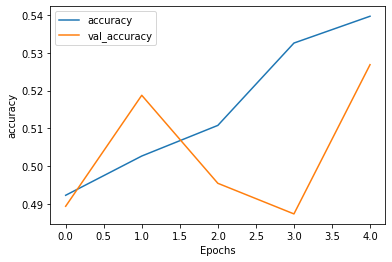

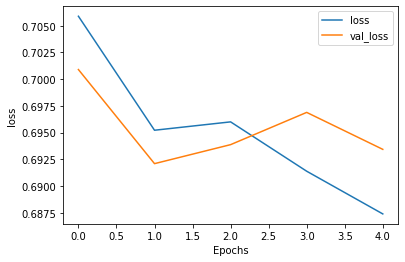

In [42]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [56]:
print("\n Evaluating Model ... \n")
predicted = model.predict_classes(X_test_Glove)
print(metrics.classification_report(y_test, predicted.astype(str)))
print("\n")
logger = logging.getLogger("logger")
result = compute_metrics(y_test, predicted.astype(str))
for key in (result.keys()):
    logger.info("  %s = %s", key, str(result[key]))


 Evaluating Model ... 



INFO:logger:  mcc = 0.05228516548834107
INFO:logger:  true positive = 258
INFO:logger:  true negative = 261
INFO:logger:  false positive = 222
INFO:logger:  false negative = 246
INFO:logger:  pricision = 0.5375
INFO:logger:  recall = 0.5119047619047619
INFO:logger:  F1 = 0.5243902439024389
INFO:logger:  accuracy = 0.5258358662613982


              precision    recall  f1-score   support

           0       0.51      0.54      0.53       483
           1       0.54      0.51      0.52       504

    accuracy                           0.53       987
   macro avg       0.53      0.53      0.53       987
weighted avg       0.53      0.53      0.53       987



